## 基于 Embedding 与 CNN 进行文本分类

In [5]:
import tensorflow.keras as keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import sys
import time
import tensorflow as tf

In [6]:
print(tf.__version__)
print("GPU : ", tf.test.is_gpu_available())
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU :  False
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.4.2
numpy 1.18.5
pandas 1.3.3
sklearn 1.0
tensorflow 2.3.0
tensorflow.keras 2.4.0


### 1. 数据集读取与词表构建

#### 1.1 读取数据

In [7]:
# imdb 是电影评论数据集, 类别为积极与消极
imdb = keras.datasets.imdb
# 词表数量, 前 10000 个会被保存, 其他的会被当做特殊字符处理
vocab_size = 10000
# 词表的index从index_from 开始算, 因为要设置特殊字符! 0 ~ 3 是特殊字符
index_from = 3

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size, index_from=index_from)

In [8]:
# 打印向量
print(train_data[0], train_labels[0])
print(train_data.shape, train_labels.shape)
print(len(train_data[0]), len(train_data[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1
(25000,) (25000,)
218 189


In [9]:
print(test_data.shape, test_labels.shape)

(25000,) (25000,)


#### 1.2 构建词表

In [10]:
# 获取词表， word_index = (单词, 索引)
word_index = imdb.get_word_index()
print(len(word_index))

88584


In [11]:
print(type(word_index))
# 打印前10个词表
for word, index in word_index.items():
    if int(index) < 30:
        print(word, index)

<class 'dict'>
with 16
one 28
have 25
i 10
he 26
as 14
it 9
is 6
in 8
but 18
on 20
of 4
his 24
all 29
this 11
not 21
you 22
a 3
for 15
be 27
br 7
the 1
was 13
and 2
to 5
film 19
movie 17
that 12
are 23


In [12]:
# 因为之前的设置 index_from = 3, 所以所有的索引都需要偏移3
word_index = {word: (index + 3) for word, index in word_index.items()}

In [13]:
# 设置特殊字符
# <PAD> padding 的填充字符
# <START> 句子的开头的填充字符
# <UNK> 找不到字符时, 返回UNK
# <END> 句子的末尾的特殊字符

word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3
reverse_word_index = dict([(index, word) for word, index in word_index.items()])

In [14]:
# 使用词表反向解析句子
def decode_review(text_ids):
    return " ".join(
        [reverse_word_index.get(word_id, "<UNK>") for word_id in text_ids]
    )


# 解析数字为真实文本
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 2. 数据padding

- padding 就是对数据进行变长处理
    1. 处理方式: 如果数据过长, 就截断数据, 如果数据过短就使用字符(0)填充
    2. 合并
- keras.preprocessing.sequence.pad_sequences
    1. value=word_index['<PAD>'] , 使用词表中 'PAD' 对应的部分进行填充
    2. padding='post' , value : post or pre , post 就是 把 padding 放到句子的后面, pre 就是 把padding 放到句子的前面
    3. maxlen=max_length 句子的最大长度

In [15]:
# 设置的单个句子的最长的长度

max_length = 500

# 对训练数据进行padding

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data,  # integer of list
    value=word_index['<PAD>'],  # 使用词表中 'PAD' 对应的部分进行填充
    padding='post',  # value : post or pre , post 就是 把 padding 放到句子的后面, pre 就是 把padding 放到句子的前面
    maxlen=max_length  # 句子的最大长度
)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data,  # integer of list
    value=word_index['<PAD>'],  # 使用词表中 'PAD' 对应的部分进行填充
    padding='post',  # value : post or pre , post 就是 把 padding 放到句子的后面, pre 就是 把padding 放到句子的前面
    maxlen=max_length  # 句子的最大长度
)

# 打印样本
print(train_data.shape)

(25000, 500)


### 3. 模型构建

用一个例子解释textCNN的设计 :
1. 这里的输入是一个有11个词的句子，每个词用6维词向量表示。因此输入序列的宽为11，输入通道数为6。
2. 给定2个一维卷积核，核宽分别为2和4，输出通道数分别设为4和5。
3. 因此，一维卷积计算后，4个输出通道的宽为11−2+1=10, 而其他5个通道的宽为11−4+1=8。
4. 尽管每个通道的宽不同，我们依然可以对各个通道做时序最大池化，并将9个通道的池化输出连结成一个9维向量。最终，使用全连接将9维向量变换为2维输出，即正面情感和负面情感的预测



In [19]:
# 每个word都转换成长度为 16 的向量
# 每个词用长度为 embedding_dim 的向量表示
embedding_dim = 16
# 每个单词的最大长度(文本序列长度)
sentence_max_length = max_length
# 输入样本的宽为sentence_max_length, 高为1, 输入通道数为embedding_dim

batch_size = 128

# 定义模型
text_cnn_model = keras.models.Sequential([
    # 1. 定义一个 [vocab_size, embedding_dim] 的矩阵
    # 2. 注意 : train_data : [1, 14, 22, 16, 43, 530, 973, ... ] 类似于这样的索引, 1 . 14 这种的是词表中对应单词的索引
    # 3. embedding 对每一个单词生成一个长度为 embedding_dim(16) 的向量(是向量不是矩阵, 是一维的, 注意是每一个单词)
    # 4. 一个句子 train_data[i] 会生成一个 embedding_dim * max_length 的二位矩阵 [max_length, embedding_dim]
    # 5. 最终会生成一个 batch_size * max_length * embedding_dim 的 三维矩阵
    keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
    ),
    # 添加一维卷积层
    # filters : 卷积核的数量
    # kernel_size : 卷积核的大小
    # padding : 要不要给输入输出加上padding, 让输入和输出大小一样
    keras.layers.Conv1D(filters= 64, kernel_size=3, padding="valid", strides=1, activation='relu'),
    keras.layers.MaxPool1D(),
    keras.layers.Conv1D(filters= 64, kernel_size=4, padding="valid", strides=1, activation='relu'),
    keras.layers.MaxPool1D(),
    keras.layers.Conv1D(filters= 64, kernel_size=5, padding="valid", strides=1, activation='relu'),
    keras.layers.MaxPool1D(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128),
    # dropout
    keras.layers.Dropout(rate=0.2),
    keras.layers.ReLU(),
    # 输出分类结果
    keras.layers.Dense(1, activation="softmax")
])

text_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 498, 64)           3136      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 246, 64)           16448     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 123, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 119, 64)           20544     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 59, 64)           

- Adam Optimizer是对SGD的扩展，可以代替经典的随机梯度下降法来更有效地更新网络权重
    1. 计算效率高
    2. 很少的内存需求
    3. 梯度的对角线重缩放不变（这意味着亚当将梯度乘以仅带正因子的对角矩阵是不变的，以便更好地理解此堆栈交换）
    4. 非常适合数据和/或参数较大的问题
    5. 适用于非固定目标
    6. 适用于非常嘈杂和/或稀疏梯度的问题
    7. 超参数具有直观的解释，通常需要很少的调整（我们将在配置部分中对此进行详细介绍）

- binary_crossentropy : 二进制交叉熵
    1. 参考 : https://blog.csdn.net/qq_35599937/article/details/105608354

In [20]:
text_cnn_model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [21]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3)
]
history = text_cnn_model.fit(
    train_data, train_labels, epochs=30, batch_size=batch_size,
    validation_split=0.2,  # 设置验证集为 20%
    callbacks=callbacks
)

Epoch 1/30
157/157 [==============================] - 31s 195ms/step - loss: 0.0000e+00 - accuracy: 0.5016 - val_loss: 0.0000e+00 - val_accuracy: 0.4938

In [22]:
history.history

{'loss': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'accuracy': [0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384,
  0.501550018787384],
 'val_loss': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,


### 4. 绘制图像

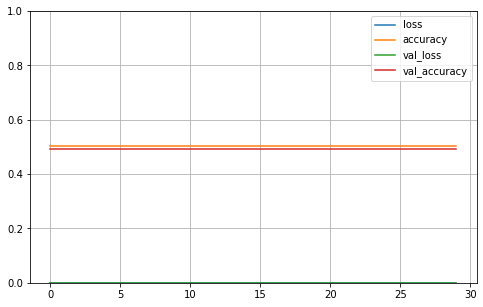

In [27]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [28]:
# 使用测试集进行验证
text_cnn_model.evaluate(test_data, test_labels, batch_size=batch_size)

196/196 [==============================] - 10s 51ms/step - loss: 0.0000e+00 - accuracy: 0.5000

[0.0, 0.5]